## Redes Neuronales Gender Bias

## 0. Descarga y limpieza del dataset

In [1]:
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Descarga (solo la primera vez)
!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv

# Cargar CSV con codificación correcta y quedarnos con columnas relevantes
df = (pd.read_csv("Gender_bias_spanish.csv", encoding="ISO-8859-1"))

df.head()

--2025-05-28 15:53:21--  https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv [following]
--2025-05-28 15:53:21--  https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205292 (200K) [text/plain]
Saving to: ‘Gender_bias_spanish.csv’

Gender_bias_s

,Contents,Label
0,@chumeltorres ya cabrÃ³n! sin tÃ­ se reciben l...,biased
1,Â¿alguien es tan amable de ir a hacerme la com...,non-biased
2,"@jenniferduquee hahaha, si estÃ¡ rico, nadamas...",non-biased
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased
4,como siempre mi tortilla triunfa mas que otros...,non-biased


In [2]:
df.isnull().sum()

,0
Contents,0
Label,0


## 1. Configuración y seed

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(42)
tf.random.set_seed(42)


## 2. División Train/Test

In [4]:
y = df['Label'].map({'biased':0,'non-biased':1})
X_train, X_test, y_train, y_test = train_test_split(
    df['Contents'], y, test_size=0.2, stratify=y, random_state=42)

print(len(X_train),"train |", len(X_test),"test")

1531 train | 383 test


## 3. Vectorización de texto con manejo seguro de dimensiones

In [5]:
MAX_TOKENS, MAX_LEN = 10000, 100
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation")
vectorizer.adapt(X_train.values)

def to_tensor(txt, label):
    txt = tf.expand_dims(txt, -1)          # (1,)
    seq = tf.squeeze(vectorizer(txt), axis=0) # (MAX_LEN,)
    return seq, label

batch = 32
train_ds = (tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
            .shuffle(10000)
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))
test_ds  = (tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))

## 4. Definición y entrenamiento del modelo

In [6]:
EMBED_DIM = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_TOKENS, EMBED_DIM, input_length=MAX_LEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=5)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7848 - loss: 0.5854 - val_accuracy: 0.8329 - val_loss: 0.4537
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8380 - loss: 0.4649 - val_accuracy: 0.8329 - val_loss: 0.4550
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8353 - loss: 0.4691 - val_accuracy: 0.8329 - val_loss: 0.4537
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8267 - loss: 0.4767 - val_accuracy: 0.8329 - val_loss: 0.4531
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8394 - loss: 0.4653 - val_accuracy: 0.8329 - val_loss: 0.4530


## 5. Curva de aprendizaje

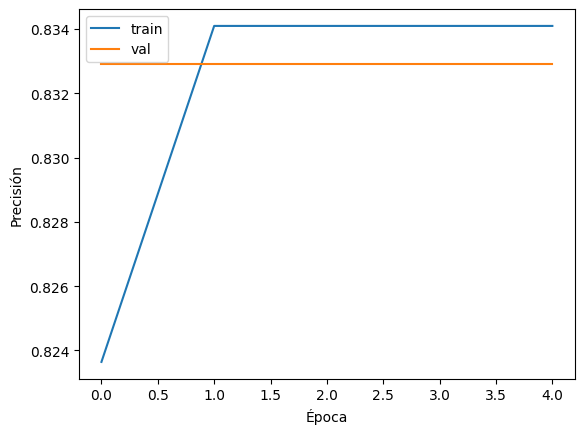

In [7]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('Época'); plt.ylabel('Precisión'); plt.show()

## 6. Evaluación

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

      biased       0.00      0.00      0.00        64
  non-biased       0.83      1.00      0.91       319

    accuracy                           0.83       383
   macro avg       0.42      0.50      0.45       383
weighted avg       0.69      0.83      0.76       383



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


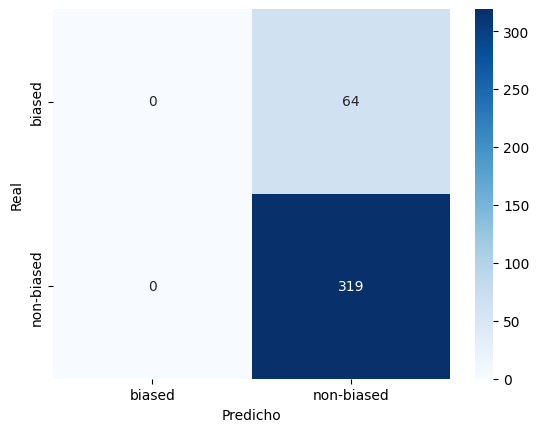

AUC: 0.4792564655172414


In [8]:
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob > 0.4).astype(int)
y_true = y_test.values

print(classification_report(y_true, y_pred, target_names=['biased','non-biased']))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['biased','non-biased'], yticklabels=['biased','non-biased'])
plt.xlabel('Predicho'); plt.ylabel('Real'); plt.show()

fpr,tpr,_ = roc_curve(y_true, y_prob)
print("AUC:", auc(fpr,tpr))